In [1]:
import torch
from torchvision import models, transforms
from ig import integrated_gradients
from ig_utils import get_gradients
from visualize import visualize
import requests

import skimage.io as io
from skimage.color import gray2rgb

from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
device = torch.device("cuda:0")
model = models.resnet152(pretrained=True).to(device).eval();

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize,
    ]
)

def transform_img(image, preprocess):
    image_tensor = preprocess(Image.fromarray(image))
    image = (
        image_tensor.cpu().numpy()/ image_tensor.abs().max().item()
    )
    return np.expand_dims(image, 0)

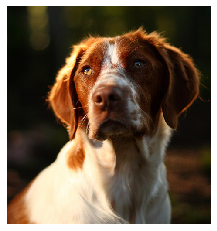

In [4]:
I = io.imread('../../demos/2. image classification/dog.jpg')

if len(I.shape) == 2:
    I = gray2rgb(I)
plt.imshow(I); plt.axis('off')


image = Image.fromarray(I)
image = transform_img(I, preprocess)

In [5]:
target_label_idx = model(torch.FloatTensor(image).to(device)).data.cpu().numpy()[0].argsort()[::-1][0]

In [6]:
i1k_labels_url ="https://s3.amazonaws.com/outcome-blog/imagenet/labels.json"

i1k_labels = {
    int(key): value for (key, value) in requests.get(i1k_labels_url).json().items()
}
i1k_labels[target_label_idx]

'Brittany spaniel'

In [7]:
integrated_grad = integrated_gradients(image.squeeze(), model, target_label_idx, get_gradients, None, device, steps=50)
integrated_grad = np.transpose(integrated_grad, (1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

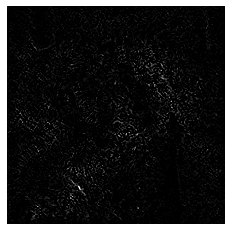

In [8]:
new_img = np.tile(np.expand_dims(integrated_grad.sum(2),2),3)

plt.imshow(new_img); plt.axis('off')